# Machine Learning

### 1. Can you project the sales amount in each nation in the next ... months/ years?  

## Import Library

In [1]:
# Import Library
import pandas as pd
import os

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

Matplotlib is building the font cache; this may take a moment.


## Prepare Data

In [2]:
data_dir = "clean_data"
OCNR = pd.read_csv(f"{data_dir}/OCNR.csv")
SNR = pd.read_csv(f"{data_dir}/SNR.csv")
L = pd.read_csv(f"{data_dir}/L.csv")
P = pd.read_csv(f"{data_dir}/P.csv")
PS = pd.read_csv(f"{data_dir}/PS.csv")

In [3]:
LOCNR = pd.merge(left = L,
                 right=OCNR,
                 left_on='L_ORDERKEY',
                 right_on='O_ORDERKEY',
                 how='inner')

In [5]:
AGG_df = LOCNR.groupby(['C_NATION','C_REGION','O_ORDERYEAR','O_ORDERMONTH'],as_index=False).agg({
    'L_QUANTITY':'sum',
    'L_DISCOUNT':'mean',
    'L_EXTENDEDPRICE':'mean',
    'L_TAX':'mean',
    'LEADDAY':'mean',
    'O_TOTALPRICE':'sum'
})

In [6]:
AGG_df.head()

,C_NATION,C_REGION,O_ORDERYEAR,O_ORDERMONTH,L_QUANTITY,L_DISCOUNT,L_EXTENDEDPRICE,L_TAX,LEADDAY,O_TOTALPRICE
0,ALGERIA,AFRICA,1992,1,249,0.06,33130.12,0.05,8.67,2165524.83
1,ALGERIA,AFRICA,1992,2,497,0.06,42401.56,0.03,32.25,2320605.59
2,ALGERIA,AFRICA,1992,3,1150,0.05,36720.46,0.04,32.74,6811359.52
3,ALGERIA,AFRICA,1992,4,920,0.05,32985.09,0.04,51.09,6702963.88
4,ALGERIA,AFRICA,1992,5,985,0.05,38136.41,0.04,81.24,7597916.96


In [7]:
AGG_df['MONTHYEAR'] = pd.to_datetime(dict(year=AGG_df.O_ORDERYEAR, month=AGG_df.O_ORDERMONTH, day=1))

## Linear Regression

### Split by Nation

In [8]:
by_nations = []
for nation in AGG_df['C_NATION'].unique():
    nation_df = AGG_df[AGG_df['C_NATION']==nation]
    by_nations.append(nation_df)

### Train Model

In [9]:
# Predict totalprice up to a specified end date
def predict_totaL_price_until_date(_df: pd.DataFrame, end_date:str, model: Pipeline):
    _nation = _df['C_NATION'].iloc[0]
    _region = _df['C_REGION'].iloc[0]

    # Convert back to datetime to generate period via date_range
    _df['MONTHYEAR'] = pd.to_datetime(_df['MONTHYEAR'], format='%Y%m')

    # Create a DataFrame for prediction up to end_date
    future_dates = pd.date_range(start=_df['MONTHYEAR'].max(), end=end_date, freq='ME').to_period('M').strftime('%Y%m')
    future_df = pd.DataFrame({
        'C_REGION': [f'{_region}'] * len(future_dates),
        'C_NATION': [f'{_nation}'] * len(future_dates),
        'MONTHYEAR': future_dates
    })

    # Converse into one format yyyymm
    _df['MONTHYEAR'] = _df['MONTHYEAR'].dt.strftime('%Y%m')
    _df = pd.concat([_df, future_df])

    # Ensure monthyear is eligible datetype
    # Re-convert monthyear from period (date_range) back to int
    _df['MONTHYEAR'] = _df['MONTHYEAR'].astype(int)
    _df['PREDICTEDTOTALPRICE'] = model.predict(_df[['C_REGION', 'C_NATION', 'MONTHYEAR']])
    
    return _df

# Plotting
def plot_actual_vs_predicted(_df: pd.DataFrame):
    # String of nation name
    _nation_str = _df['C_NATION'].iloc[0].lower()
    # _dates = _df['MONTHYEAR'].unique()
    # _min_date = pd.to_datetime(min(_dates))
    # _max_date = pd.to_datetime(max(_dates))

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot actual TOTAL_PRICE
    plt.scatter(_df['MONTHYEAR'],
             _df['O_TOTALPRICE'],
             marker='o',
             color='b',
             label='Actual TOTAL PRICE'
             )
    
    # Plot predicted TOTAL_PRICE for the entire dataset
    plt.plot(_df['MONTHYEAR'],
             _df['PREDICTEDTOTALPRICE'],
             marker='o',
             linestyle='-',
             color='r',
             label='PREDICTED TOTAL PRICE'
             )
    # plt.xlim(_min_date,_max_date)

    plt.xlabel('MONTH YEAR')
    plt.ylabel('TOTAL PRICE')
    plt.title(f'{_nation_str.upper()}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    return plt

### Result

___________________________
Country: algeria
Mean Squared Error: 45099912412860.21
R-squared: -0.14944760499105647
Coefficients:
MONTHYEAR: 20361.985605205664
___________________________
Country: argentina
Mean Squared Error: 45723900451238.85
R-squared: 0.06439154683967863
Coefficients:
MONTHYEAR: 15661.640485320691
___________________________
Country: brazil
Mean Squared Error: 33682761719449.312
R-squared: -0.055717154572874295
Coefficients:
MONTHYEAR: 14397.089311610203
___________________________
Country: canada
Mean Squared Error: 35145180514438.137
R-squared: 0.14642181987016023
Coefficients:
MONTHYEAR: 19697.86038122021
___________________________
Country: china
Mean Squared Error: 17312620661773.697
R-squared: 0.40918829297000137
Coefficients:
MONTHYEAR: 19066.734320479198
___________________________
Country: egypt
Mean Squared Error: 31154968607511.535
R-squared: -0.1302395258782616
Coefficients:
MONTHYEAR: 18056.982816642412
___________________________
Country: ethiopia
Mean

/var/folders/53/x49yqccd0r78tkl0172f7dbr0000gn/T/ipykernel_34629/1300172472.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


___________________________
Country: saudi arabia
Mean Squared Error: 25219900512565.668
R-squared: 0.12027712488431297
Coefficients:
MONTHYEAR: 16040.632142468541
___________________________
Country: united kingdom
Mean Squared Error: 33447344068997.516
R-squared: -0.1507788980360718
Coefficients:
MONTHYEAR: 11835.771991342077
___________________________
Country: united states
Mean Squared Error: 45560107975338.61
R-squared: 0.07612702320885467
Coefficients:
MONTHYEAR: 16712.83225530005
___________________________
Country: vietnam
Mean Squared Error: 69907605947464.26
R-squared: -0.15632817173148772
Coefficients:
MONTHYEAR: 11736.84817759747


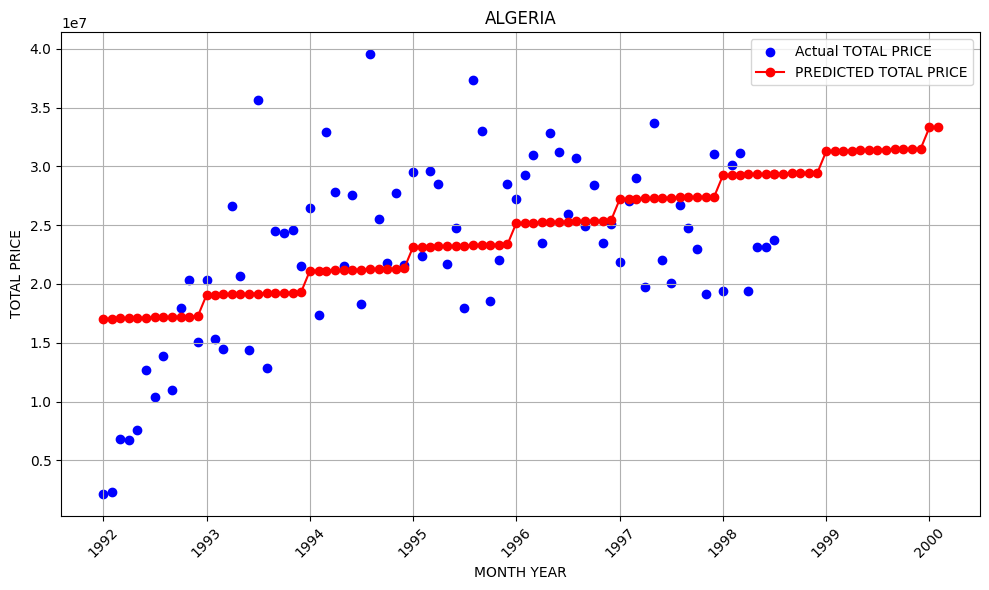

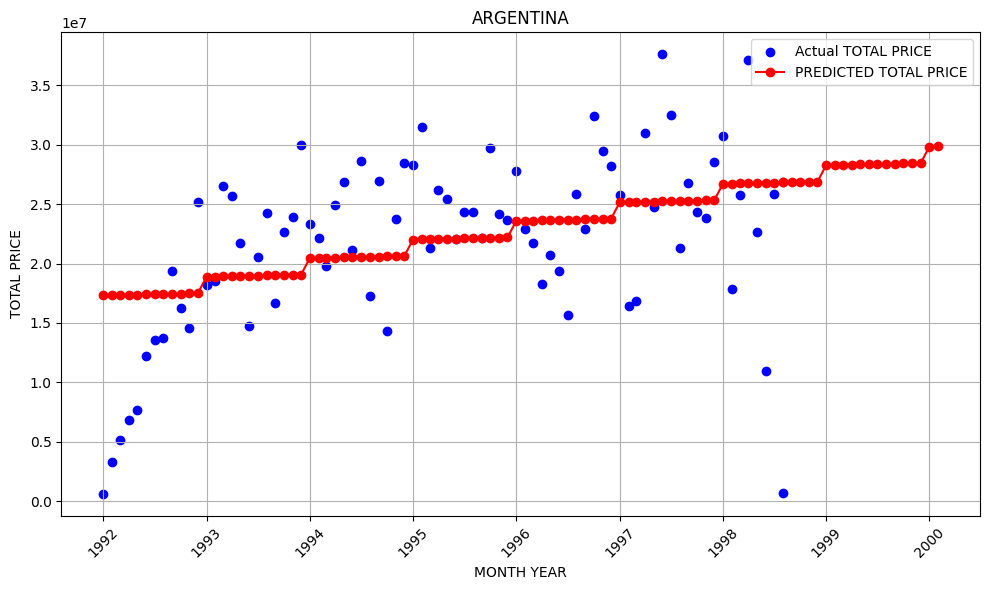

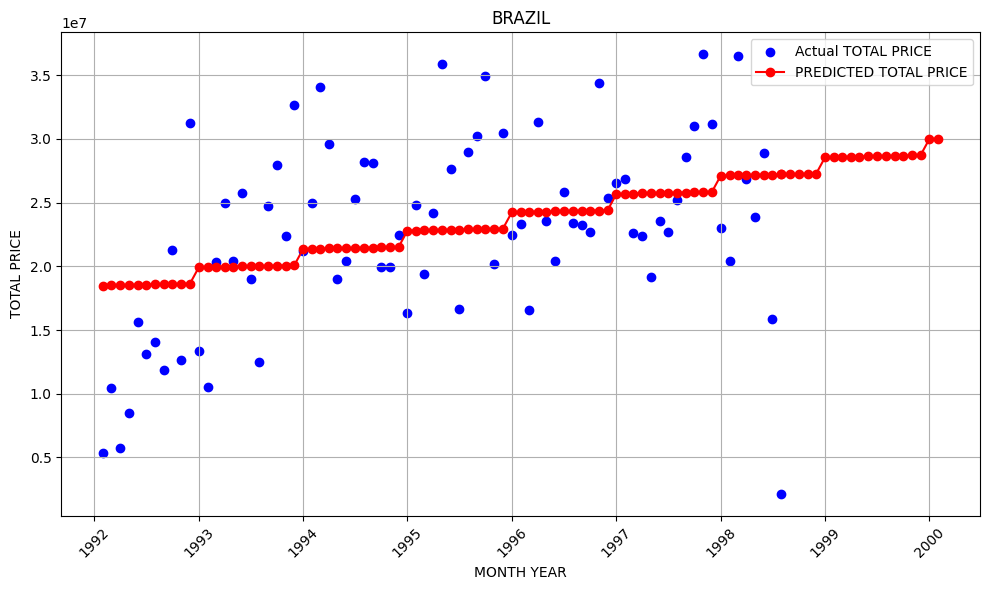

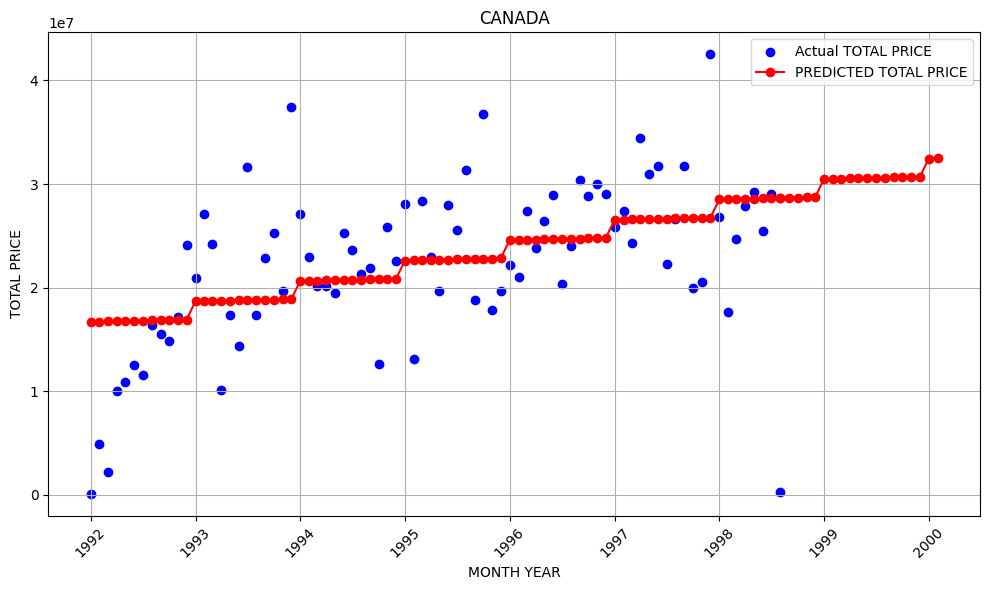

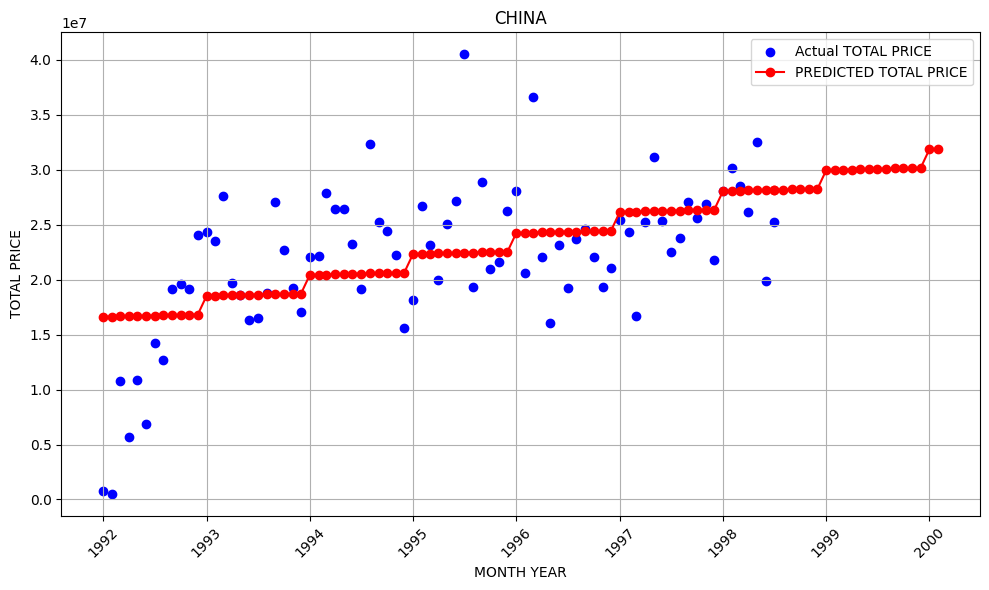

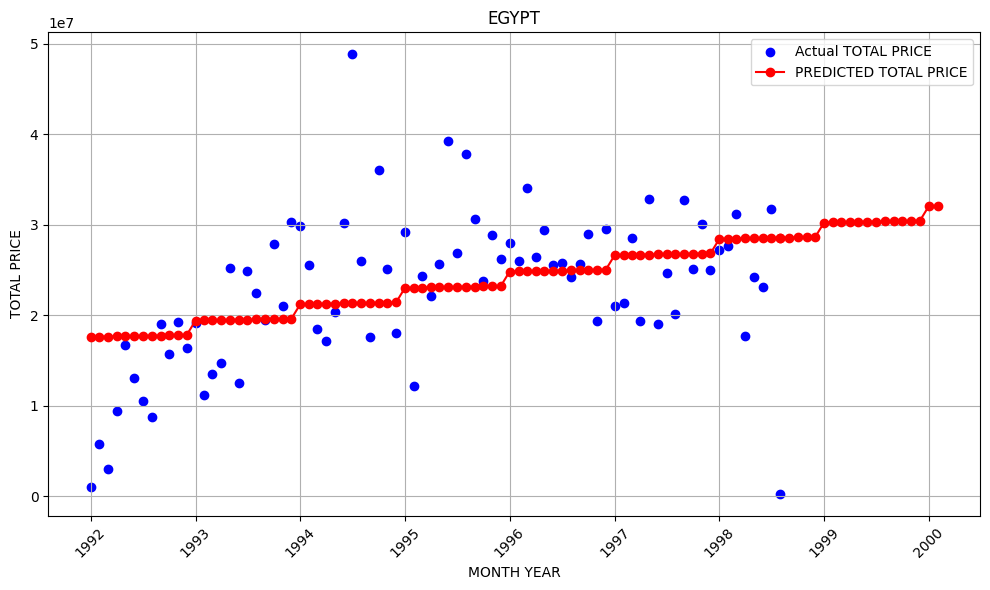

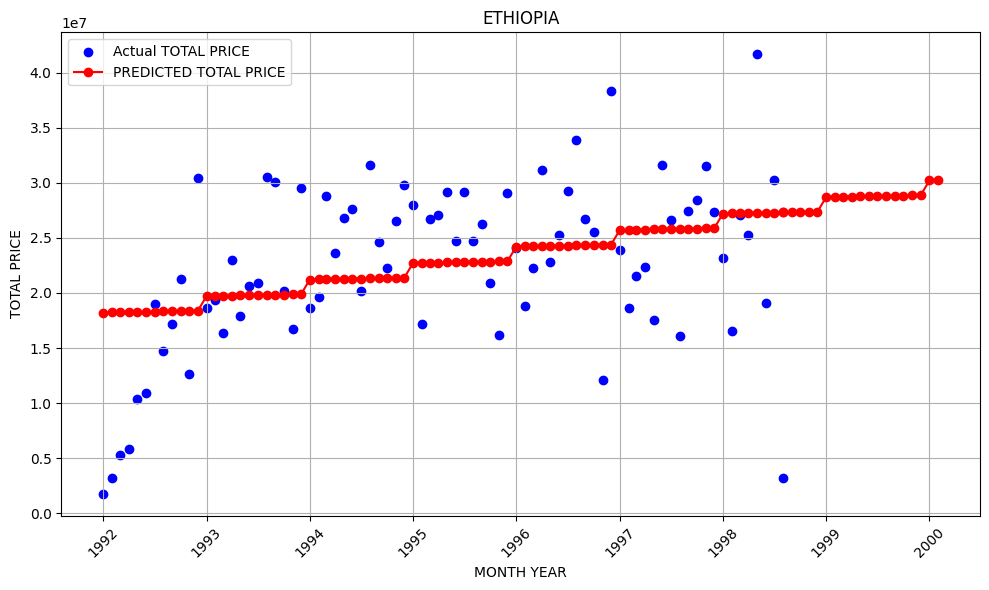

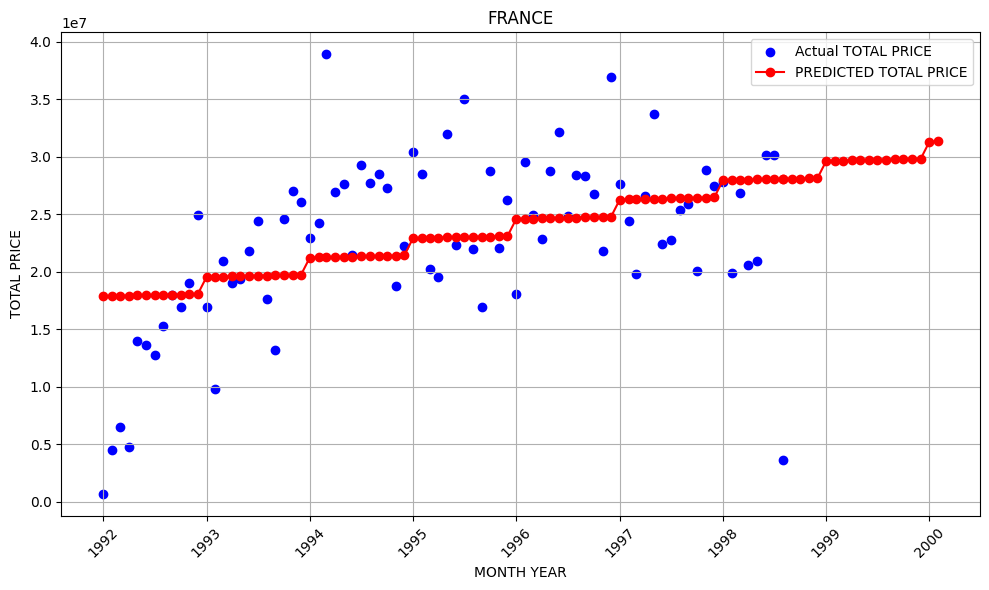

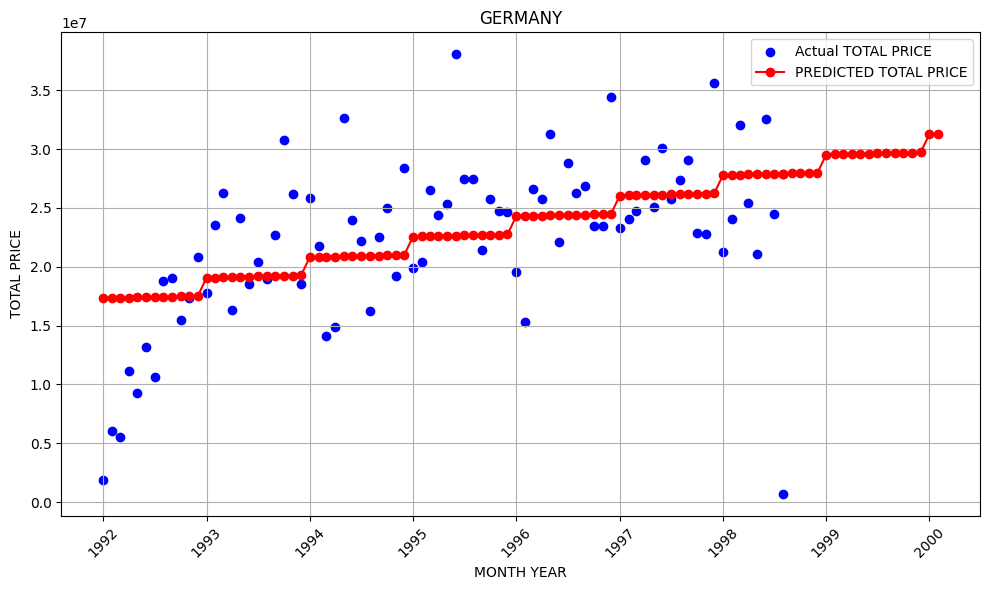

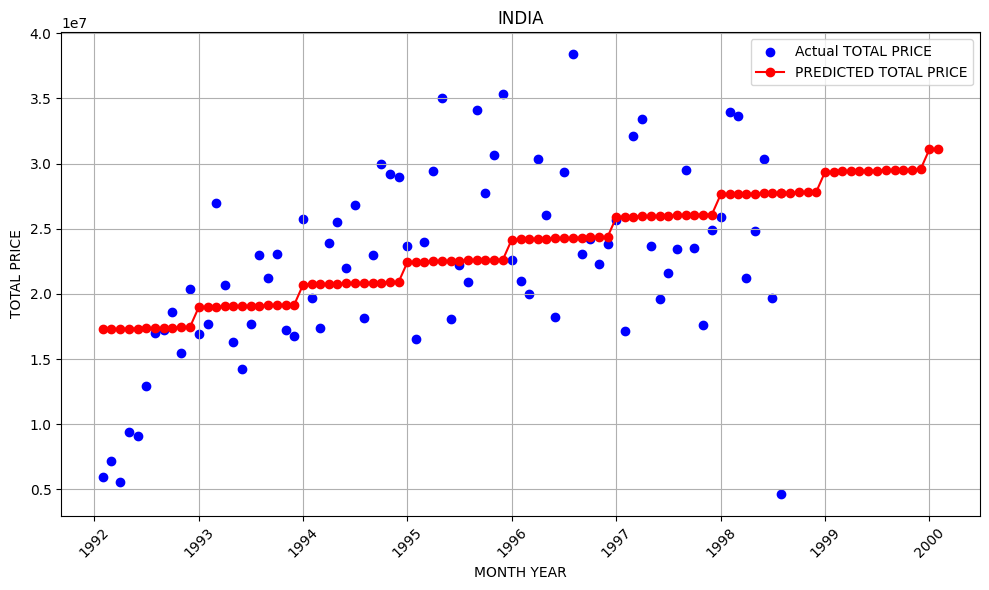

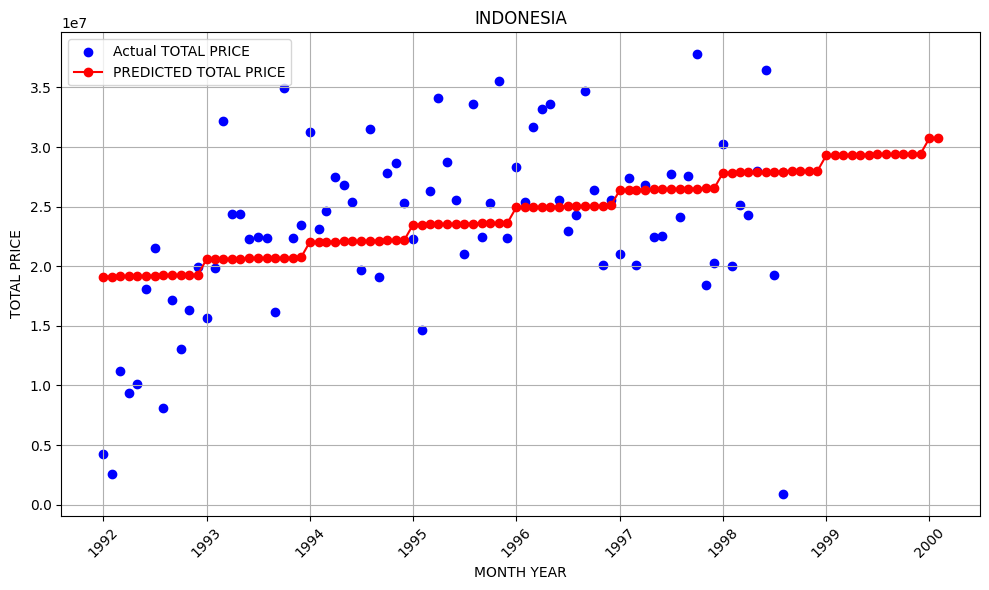

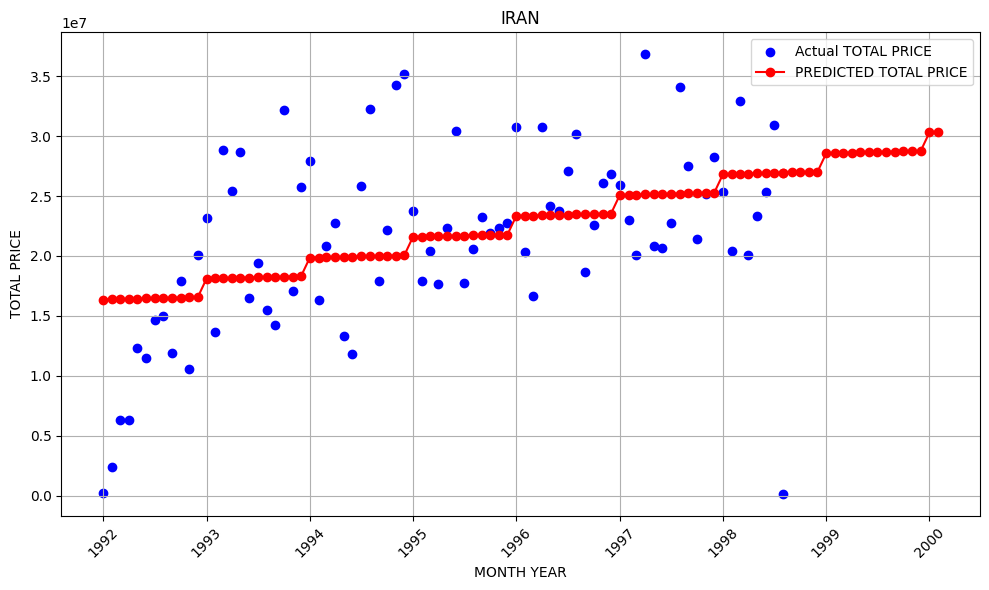

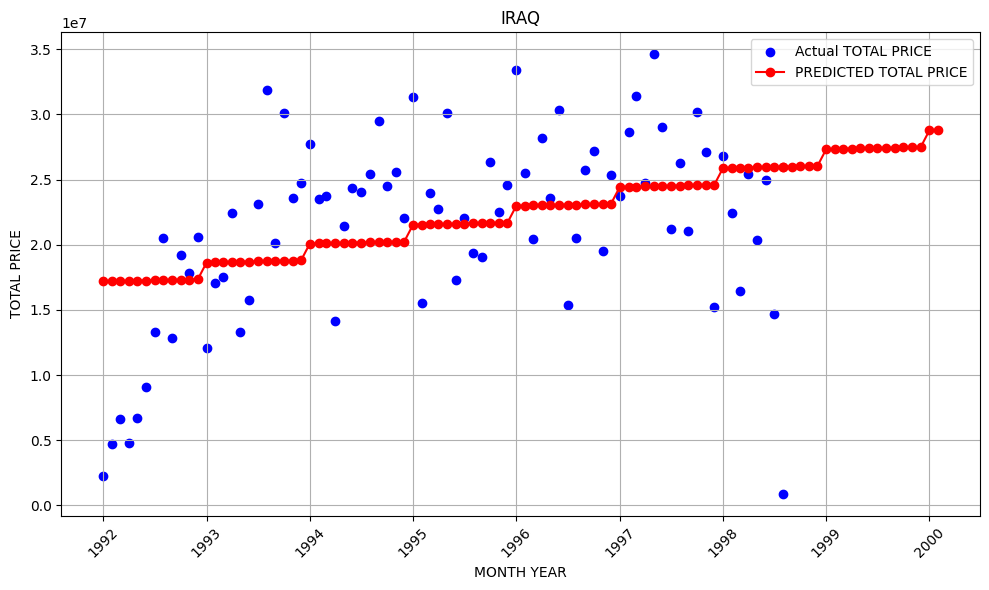

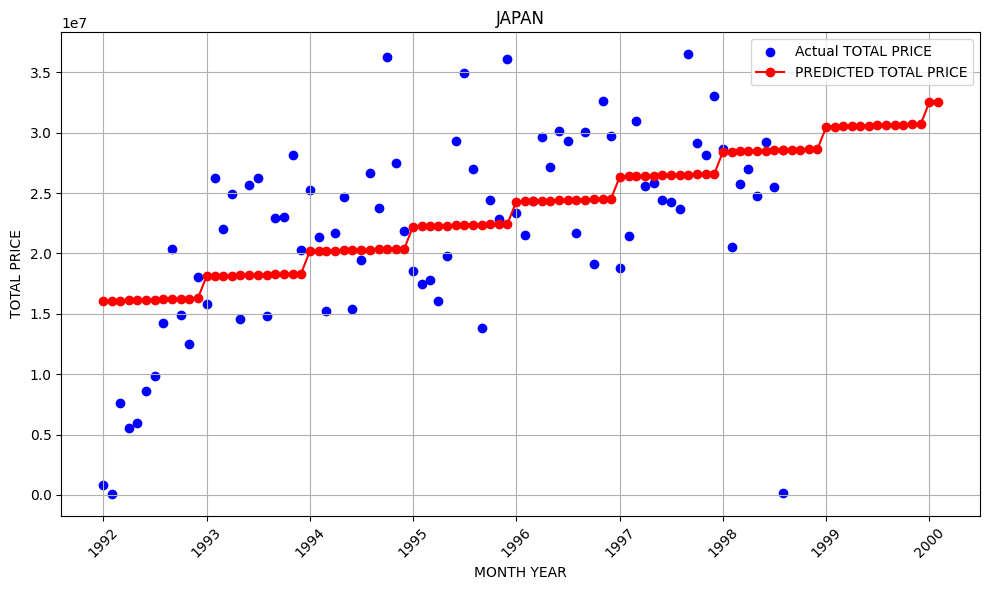

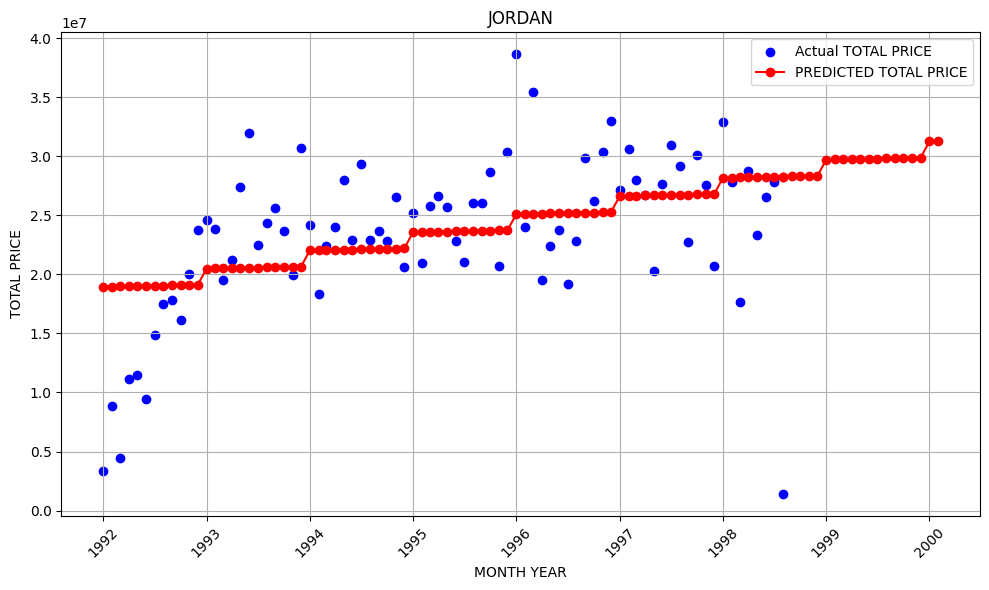

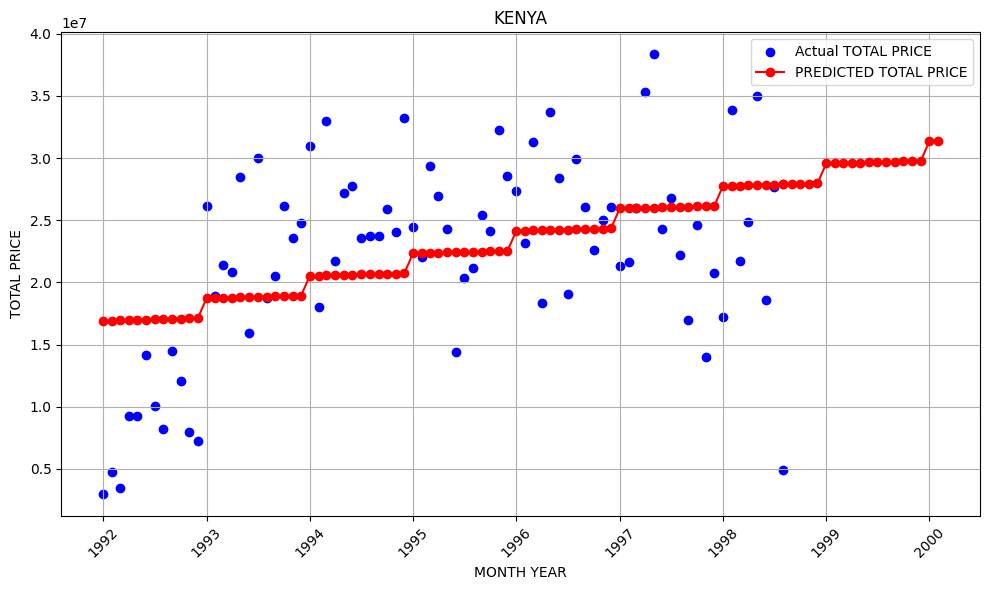

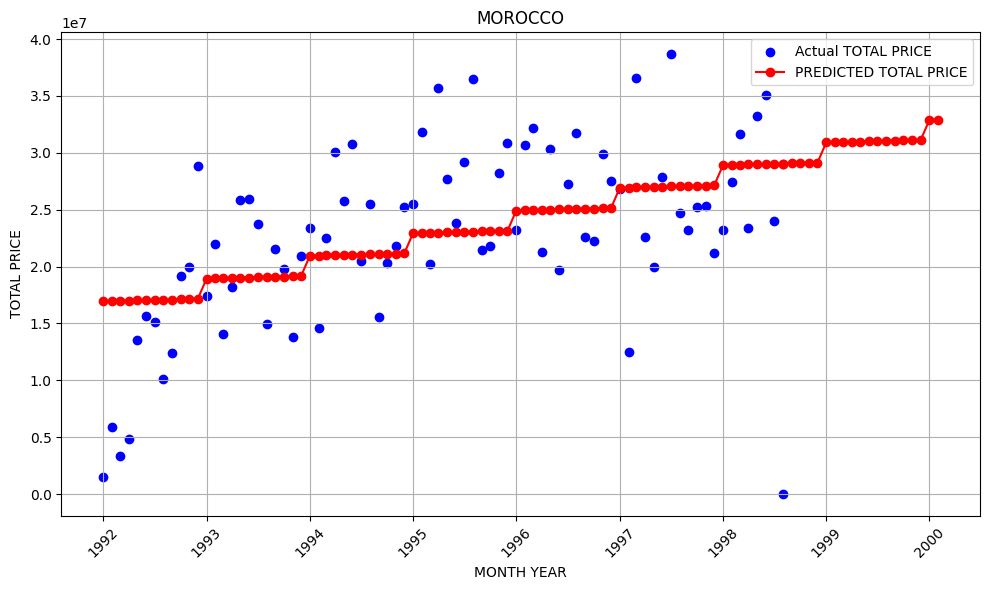

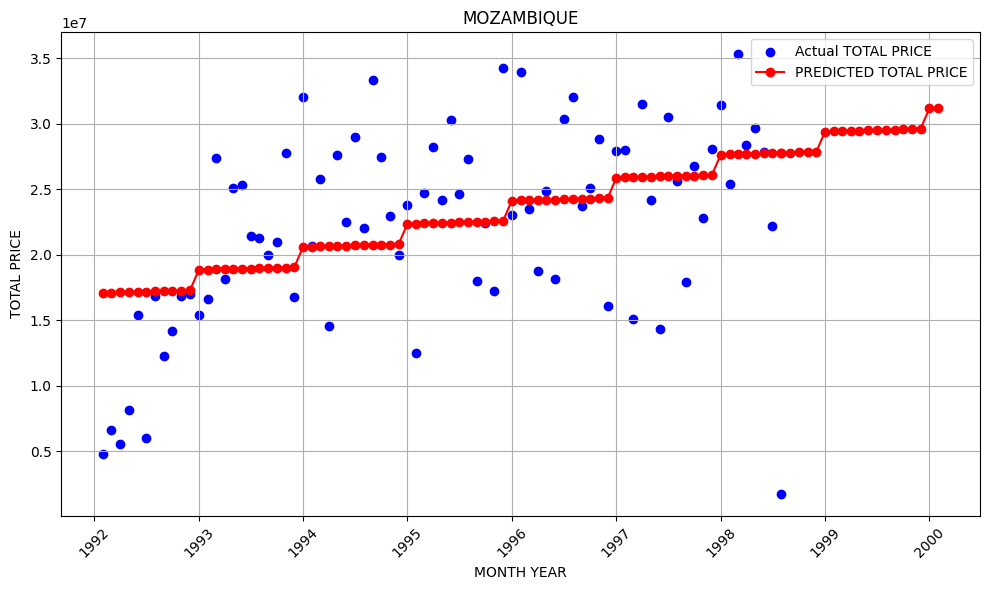

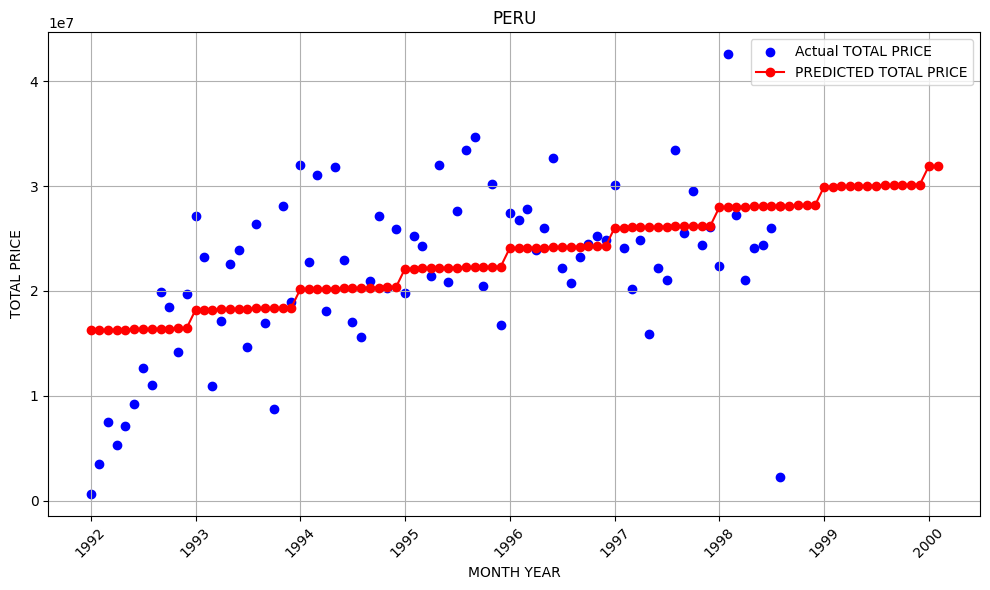

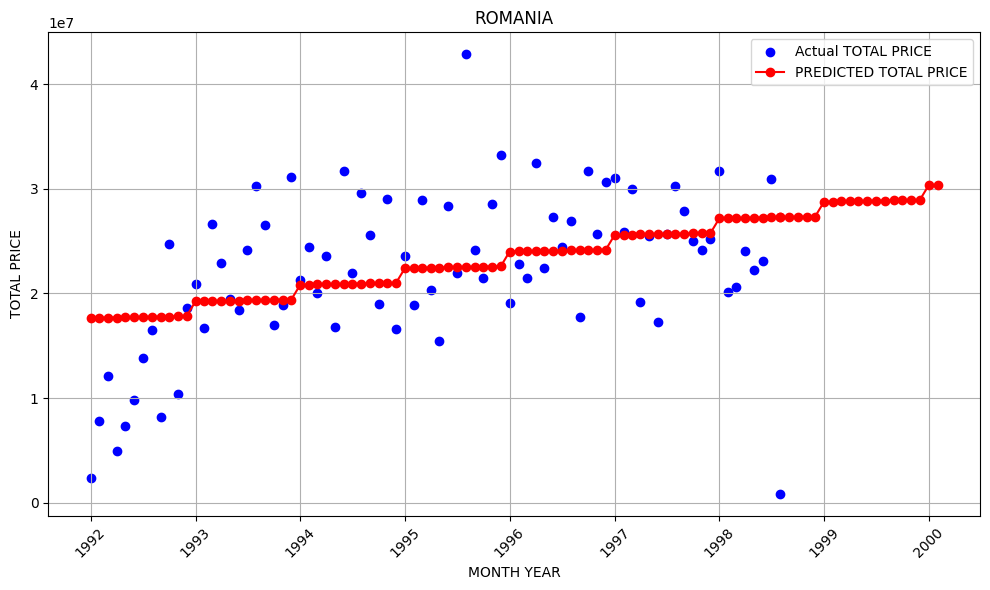

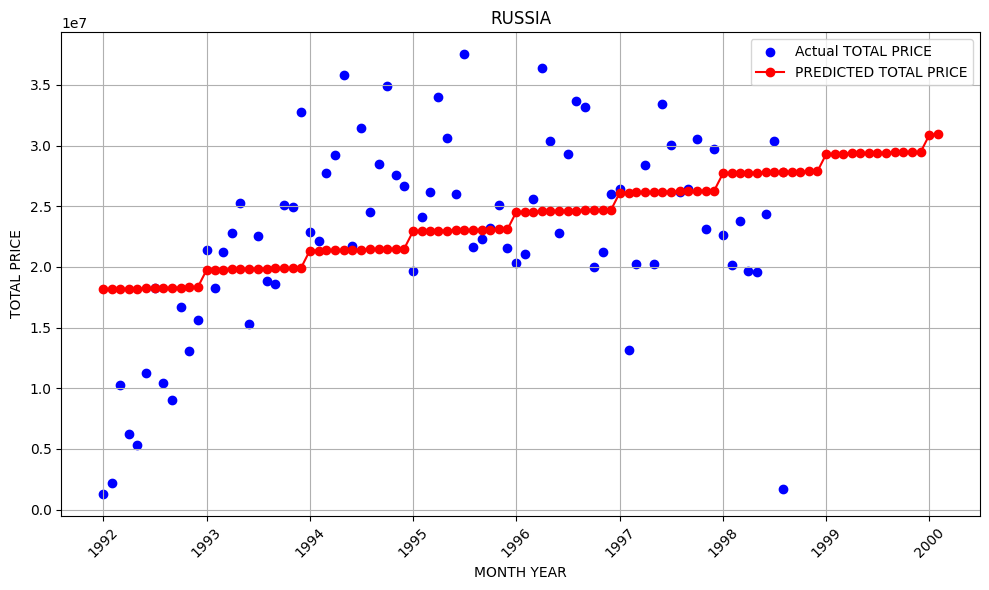

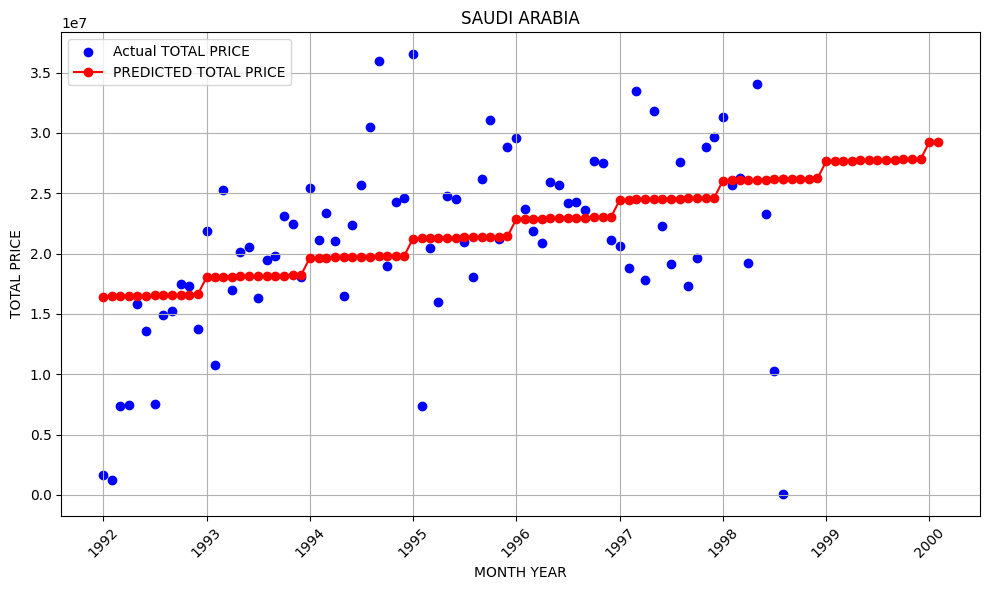

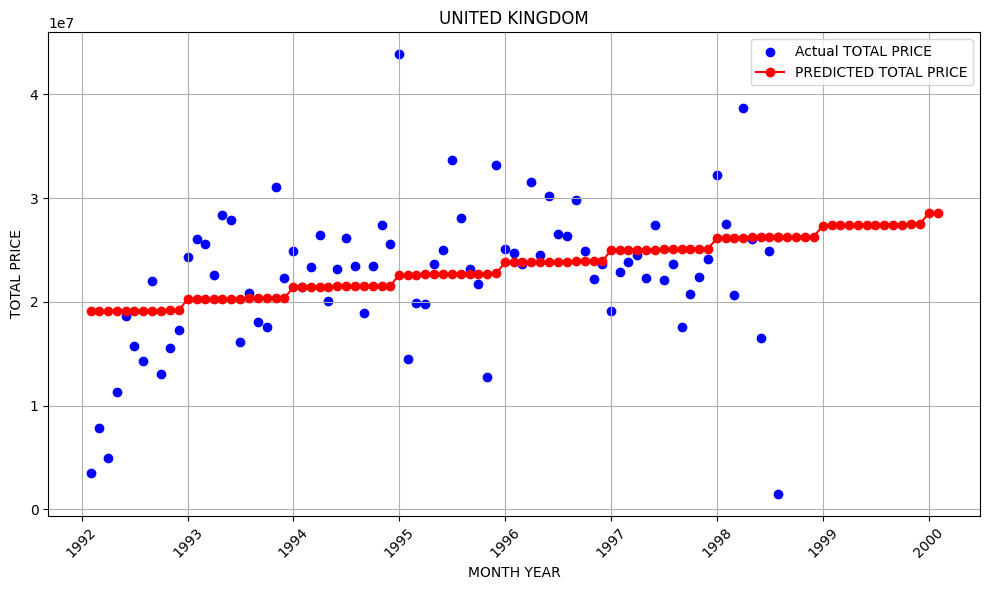

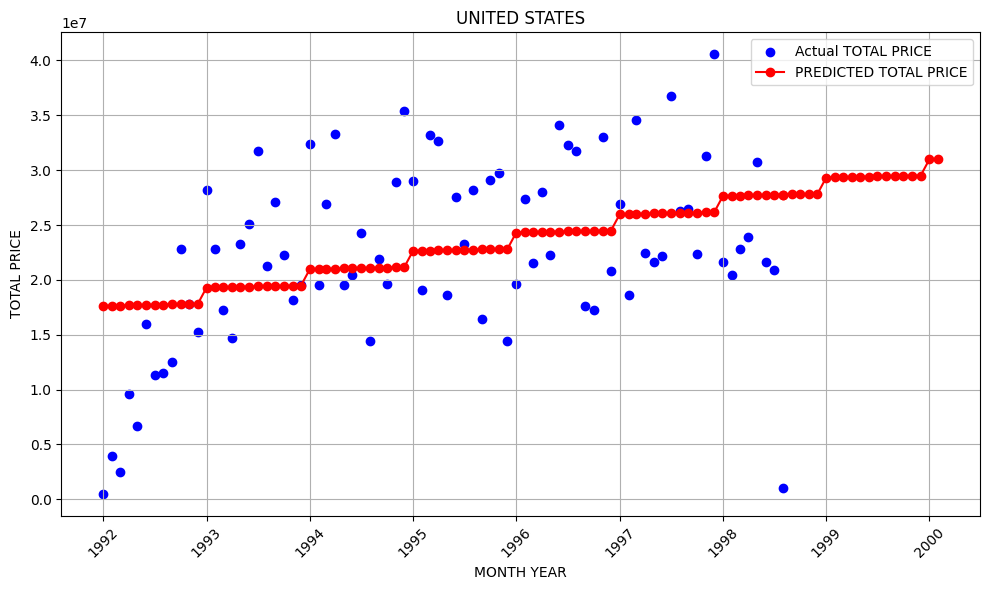

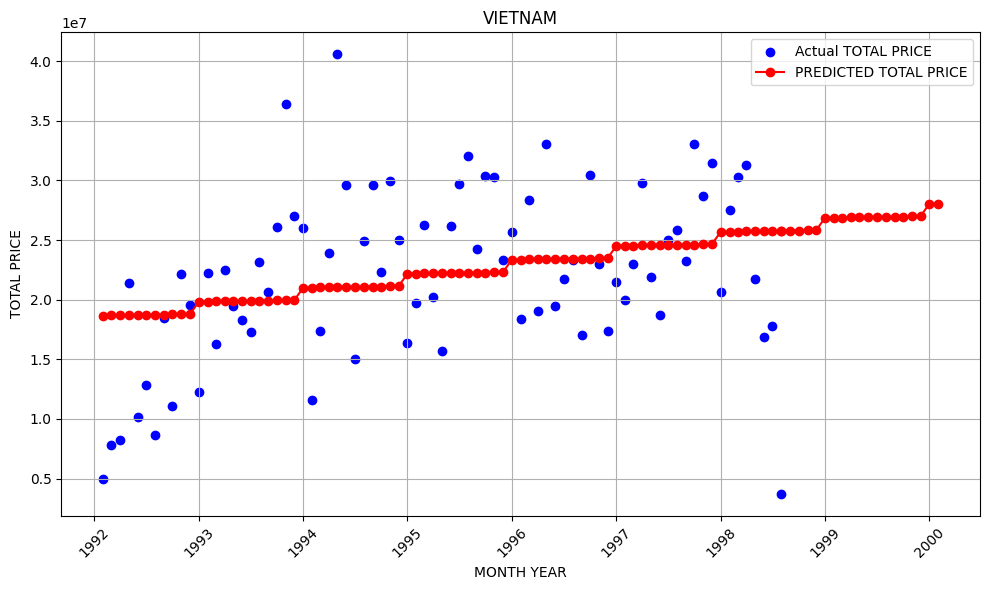

In [10]:
results = []
result_df = pd.DataFrame()

# _i=0
# by_nations = []
# for nation in AGG_df['C_NATION'].unique():
#     nation_df = AGG_df[AGG_df['C_NATION']==nation]
#     by_nations.append(nation_df)
# for _nation_df in by_nations:

for _i, (nation, _nation_df) in enumerate(AGG_df.groupby("C_NATION")):
    # Define feature, yhat
    X = _nation_df[['C_REGION', 'C_NATION', 'MONTHYEAR']]
    y = _nation_df['O_TOTALPRICE']

    # String of nation name
    _nation_str = X['C_NATION'].iloc[0].lower()

    # Ensure monthyear is eligible datetype
    X['MONTHYEAR'] = X['MONTHYEAR'].dt.strftime('%Y%m').astype(int)

    # One-hot encode, categorical varialbels using sklearn column transformer
    _preprocessor = ColumnTransformer(
        transformers=[
            # drop first category in each feature
            # Default is None
            ('category', OneHotEncoder(drop='first'), ['C_REGION', 'C_NATION'])
        ],
        remainder='passthrough' # don't encode month year
    )

    # Create a pipeline with preprocessor and Linear Regression model
    model = Pipeline(steps=[
        ('preprocessor', _preprocessor),
        ('regressor', LinearRegression())
    ])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234) # random state is basically random seed

    # Fit the model
    model.fit(X, y)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print immediate result
    print('___________________________')
    print(f'Country: {_nation_str}')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Get model coefficients
    regressor = model.named_steps['regressor']
    feature_names = _preprocessor.named_transformers_['category'].get_feature_names_out(['C_REGION', 'C_NATION']).tolist() + ['MONTHYEAR']
    coefficients = regressor.coef_

    print('Coefficients:')
    for feature, coef in zip(feature_names, coefficients):
        print(f'{feature}: {coef}')

    # Specify the end date for predictions
    end_date = '2000-03-01'

    # Combine back X and y
    X = pd.concat([X, y], axis=1)
    X = X.sort_values(by=['MONTHYEAR'])

    # Predict TOTAL_PRICE up to the specified end date
    _extented_df = predict_totaL_price_until_date(X, end_date, model)
    
    # Convert back to datetime for X axis
    _extented_df['MONTHYEAR'] = pd.to_datetime(_extented_df['MONTHYEAR'], format='%Y%m')

    # Plot
    _plot = plot_actual_vs_predicted(_extented_df)

    results.append((_i, _nation_str, _extented_df, model, _plot))
    result_df = pd.concat([result_df, _extented_df])
    # _i+=1

## Download Data

In [11]:
#Create output folder if not exist
if not os.path.exists("output"):
    os.makedirs("output")

data_dir = "output"

#Download modeled data into output folder
result_df.to_csv(f"{data_dir}/Lab1-1.csv")